In [ ]:
# Listing 5.1 Reprising Airbnb NYC dataset

import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

data = pd.read_csv("./AB_NYC_2019.csv")
excluding_list = ['price', 'id', 'latitude', 'longitude', 'host_id', 
                  'last_review', 'name', 'host_name'] #A
low_card_categorical = ['neighbourhood_group', 'room_type'] #B
high_card_categorical = ['neighbourhood'] #C
continuous = ['minimum_nights', 'number_of_reviews', 'reviews_per_month', 
              'calculated_host_listings_count', 'availability_365']
target_mean = (data["price"] > data["price"].mean()).astype(int) #D
target_median = (data["price"] > data["price"].median()).astype(int) #E
target_multiclass = pd.qcut(data["price"], q=5, labels=False) #F
target_regression = data["price"] #G
categorical_onehot_encoding = OneHotEncoder(handle_unknown='ignore')
categorical_ord_encoding = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=np.nan)
numeric_passthrough = SimpleImputer(strategy="constant", fill_value=0)

column_transform = ColumnTransformer(
    [('low_card_categories', categorical_onehot_encoding, low_card_categorical),
     ('high_card_categories', categorical_ord_encoding, high_card_categorical),
     ('numeric', numeric_passthrough, continuous),
    ],
    remainder='drop',
    verbose_feature_names_out=False,
    sparse_threshold=0.0) #H

#A list of features to be excluded from data processing
#B list of low-cardinality categorical features to be one-hot encoded
#C list of high-cardinality categorical features to be ordinally encoded
#D creating a binary target indicating whether the price is above the mean (unbalanced binary target)
#E creating a binary target indicating whether the price is above the median (balanced binary target)
#F creating a multiclass target by quantile binning the price into 5 classes
#G setting the target for regression as the price column
#H creating a column transformer that applies different transformations to different groups of features

In [ ]:
#Listing 5.2 A decision tree classifier

from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.model_selection import KFold, cross_validate

accuracy = make_scorer(accuracy_score)
cv = KFold(5, shuffle=True, random_state=0)

column_transform = ColumnTransformer(
    [('categories', categorical_onehot_encoding, low_card_categorical),
     ('numeric', numeric_passthrough, continuous)], #A
    remainder='drop',
    verbose_feature_names_out=False,
    sparse_threshold=0.0)

model = DecisionTreeClassifier(random_state=0) #B

model_pipeline = Pipeline(
    [('processing', column_transform),
     ('modeling', model)]) #C

cv_scores = cross_validate(estimator=model_pipeline, 
                           X=data, 
                           y=target_median,
                           scoring=accuracy,
                           cv=cv, 
                           return_train_score=True,
                           return_estimator=True) #D

mean_cv = np.mean(cv_scores['test_score'])
std_cv = np.std(cv_scores['test_score'])
fit_time = np.mean(cv_scores['fit_time'])
score_time = np.mean(cv_scores['score_time'])
print(f"{mean_cv:0.3f} ({std_cv:0.3f})", 
      f"fit: {fit_time:0.2f} secs pred: {score_time:0.2f} secs") #E

#A creating a column transformer that applies different transformations to categorical and numeric features
#B an instance of a decision tree classifier
#C a pipeline that sequentially applies column transformation and the decision tree model
#D a five-fold cross-validation using the defined pipeline, calculating accuracy scores, and returning additional information
#E printing the mean and standard deviation of the accuracy scores from cross-validation

0.761 (0.005) fit: 0.23 secs pred: 0.01 secs


In [ ]:
# Listing 5.3 Bagged tree-based classifier

from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

accuracy = make_scorer(accuracy_score)
cv = KFold(5, shuffle=True, random_state=0)
model = BaggingClassifier(estimator=DecisionTreeClassifier(), #A
                          n_estimators=300, 
                          bootstrap=True, #B
                          max_samples=1.0, #C
                          max_features=1.0, #D
                          random_state=0)

column_transform = ColumnTransformer(
    [('categories', categorical_onehot_encoding, low_card_categorical),
     ('numeric', numeric_passthrough, continuous)],
    remainder='drop',
    verbose_feature_names_out=False,
    sparse_threshold=0.0) #E

model_pipeline = Pipeline(
    [('processing', column_transform),
     ('modeling', model)]) #F

cv_scores = cross_validate(estimator=model_pipeline, 
                           X=data, 
                           y=target_median,
                           scoring=accuracy,
                           cv=cv, 
                           return_train_score=True,
                           return_estimator=True)

mean_cv = np.mean(cv_scores['test_score'])
std_cv = np.std(cv_scores['test_score'])
fit_time = np.mean(cv_scores['fit_time'])
score_time = np.mean(cv_scores['score_time'])
print(f"{mean_cv:0.3f} ({std_cv:0.3f})", 
      f"fit: {fit_time:0.2f} secs pred: {score_time:0.2f} secs") #G

#A creating a BaggingClassifier ensemble model based on decision trees
#B setting bootstrap sampling for the BaggingClassifier
#C setting no sampling of features for the BaggingClassifier
#D setting no sampling of data for the BaggingClassifier
#E a column transformer that applies different transformations to categorical and numeric features
#F a pipeline that sequentially applies column transformation and the bagging classifier model
#G a five-fold cross-validation using the defined pipeline and calculating accuracy scores
#H printing the mean and standard deviation of the accuracy scores from cross-validation

0.809 (0.004) fit: 30.47 secs pred: 0.68 secs


In [ ]:
# Listing 5.4 Random Forests classifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

accuracy = make_scorer(accuracy_score)
cv = KFold(5, shuffle=True, random_state=0)
model = RandomForestClassifier(n_estimators=300, 
                               min_samples_leaf=3,
                               random_state=0) #A

column_transform = ColumnTransformer(
    [('categories', categorical_onehot_encoding, low_card_categorical),
     ('numeric', numeric_passthrough, continuous)],
    remainder='drop',
    verbose_feature_names_out=False,
    sparse_threshold=0.0) #B

model_pipeline = Pipeline(
    [('processing', column_transform),
     ('modeling', model)]) #C

cv_scores = cross_validate(estimator=model_pipeline, 
                           X=data, 
                           y=target_median,
                           scoring=accuracy,
                           cv=cv, 
                           return_train_score=True,
                           return_estimator=True) #D

mean_cv = np.mean(cv_scores['test_score'])
std_cv = np.std(cv_scores['test_score'])
fit_time = np.mean(cv_scores['fit_time'])
score_time = np.mean(cv_scores['score_time'])
print(f"{mean_cv:0.3f} ({std_cv:0.3f})", 
      f"fit: {fit_time:0.2f} secs pred: {score_time:0.2f} secs") #E

#A a RandomForestClassifier with 300 estimators and a minimum number of samples at a leaf node set to 3
#B a column transformer that applies different transformations to categorical and numeric features
#C a pipeline that sequentially applies column transformation and the random forest classifier model
#D a five-fold cross-validation using the defined pipeline and calculating accuracy scores
#E printing the mean and standard deviation of the accuracy scores from cross-validation

0.826 (0.004) fit: 10.04 secs pred: 0.53 secs


In [ ]:
# Listing 5.5 Extremely randomized trees classifier

from sklearn.ensemble import ExtraTreesClassifier

accuracy = make_scorer(accuracy_score)
cv = KFold(5, shuffle=True, random_state=0)
model = ExtraTreesClassifier(n_estimators=300, 
                             min_samples_leaf=3,
                             random_state=0) #A

column_transform = ColumnTransformer(
    [('categories', categorical_onehot_encoding, low_card_categorical),
     ('numeric', numeric_passthrough, continuous)],
    remainder='drop',
    verbose_feature_names_out=False,
    sparse_threshold=0.0) #B

model_pipeline = Pipeline(
    [('processing', column_transform),
     ('modeling', model)]) #C

cv_scores = cross_validate(estimator=model_pipeline, 
                           X=data, 
                           y=target_median,
                           scoring=accuracy,
                           cv=cv, 
                           return_train_score=True,
                           return_estimator=True) #D

mean_cv = np.mean(cv_scores['test_score'])
std_cv = np.std(cv_scores['test_score'])
fit_time = np.mean(cv_scores['fit_time'])
score_time = np.mean(cv_scores['score_time'])
print(f"{mean_cv:0.3f} ({std_cv:0.3f})", 
      f"fit: {fit_time:0.2f} secs pred: {score_time:0.2f} secs") #E

#A an ExtraTreesClassifier with 300 estimators and a minimum number of samples at a leaf node set to 3
#B a column transformer that applies different transformations to categorical and numeric features
#C a pipeline that sequentially applies column transformation and the random forest classifier model
#D a five-fold cross-validation using the defined pipeline and calculating accuracy scores
#E printing the mean and standard deviation of the accuracy scores from cross-validation

0.823 (0.004) fit: 3.86 secs pred: 0.35 secs


In [ ]:
# Listing 5.6 Building a gradient boosting classifier

from sklearn.tree import DecisionTreeRegressor
import numpy as np

class GradientBoosting():
    def __init__(self, learning_rate=0.1, n_estimators=10, **params):
        self.learning_rate = learning_rate
        self.n_estimators = n_estimators
        self.params = params
        self.trees = list()
        
    def sigmoid(self, x):
        x = np.clip(x, -100, 100)
        return 1 / (1 + np.exp(-x)) #A

    def logit(self, x, eps=1e-6):
        xp = np.clip(x, eps, 1-eps)
        return np.log(xp / (1 - xp)) #B

    def gradient(self, y_true, y_pred):
        gradient =  y_pred - y_true #C
        return gradient

    def fit(self, X, y):
        self.init = self.logit(np.mean(y)) #D
        y_pred = self.init * np.ones((X.shape[0],))
        for k in range(self.n_estimators):
            gradient = self.gradient(self.logit(y), y_pred)
            tree = DecisionTreeRegressor(**self.params)
            tree.fit(X, -gradient) #E
            self.trees.append(tree)
            y_pred += self.learning_rate * tree.predict(X) #F

    def predict_proba(self, X):
        y_pred = self.init * np.ones((X.shape[0],))
        for tree in self.trees:
            y_pred += self.learning_rate * tree.predict(X) #G
        return self.sigmoid(y_pred)

    def predict(self, X, threshold=0.5):
        proba = self.predict_proba(X)
        return np.where(proba >= threshold, 1, 0)

#A sigmoid function implementation used for probability transformation that converts logits back into probabilities
#B logit function implementation used to transform probabilities into logits
#C calculating the gradient of the loss function (negative log likelihood) with respect to the predictions
#D initializing the model with the logit-transformed mean of the target values
#E fitting a decision tree regressor to the negative gradient of the log-odds transformed target
#F updating the predicted values using the output of the fitted tree,  with a learning rate factor
#G predicting back requires cumulating predictions from all the trees

In [ ]:
# Listing 5.7 Testing our gradient boosting class

from sklearn.model_selection import train_test_split

train, test = train_test_split(range(len(data)), test_size=0.2, random_state=0) #A

cls = GradientBoosting(n_estimators=300, 
                       learning_rate=0.1,
                       max_depth=4,
                       min_samples_leaf=3, 
                       random_state=0) #B

X = column_transform.fit_transform(data.iloc[train]) #C
y = target_median[train] #D

cls.fit(X, y)

Xt = column_transform.transform(data.iloc[test]) #E
yt = target_median[test] #F

preds = cls.predict(Xt)
score = accuracy_score(y_true=yt, y_pred=preds) #G
print(f"Accuracy: {score:0.5f}") #H

#A splitting the dataset indices into training and test sets using a fixed random seed
#B initializing a GradientBoosting model with specified hyperparameters
#C applying the column transformations to the training data
#D extracting the target values corresponding to the training data
#E applying the same column transformations to the test data
#F extracting the target values corresponding to the test data
#G calculating the accuracy score by comparing the predicted labels with the actual test labels
#H printing the calculated accuracy score

Accuracy: 0.82503


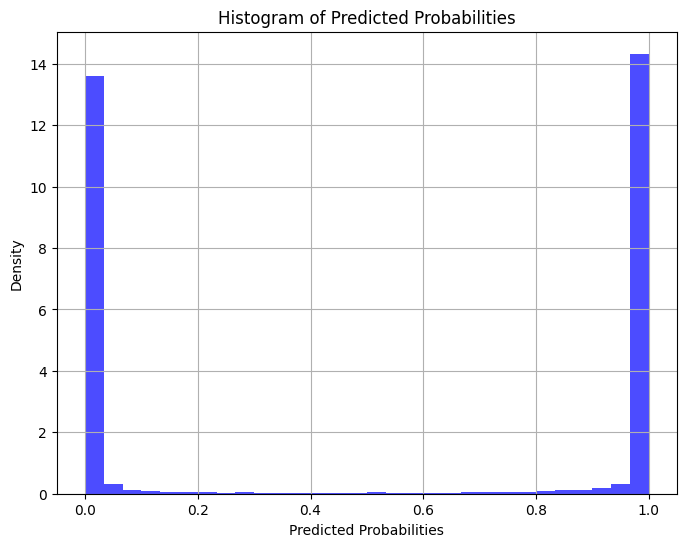

In [ ]:
# Listing 5.8 Plotting gradient boosting predicted probabilities

import matplotlib.pyplot as plt

proba = cls.predict_proba(Xt) #A
plt.figure(figsize=(8, 6))
plt.hist(proba, bins=30, density=True, color='blue', alpha=0.7) #B
plt.xlabel('Predicted Probabilities')
plt.ylabel('Density')
plt.title('Histogram of Predicted Probabilities')
plt.grid(True)
plt.show()

#A generating predicted probabilities for the test data using the trained model
#B creating a histogram of the predicted probabilities with specified bins and normalized density

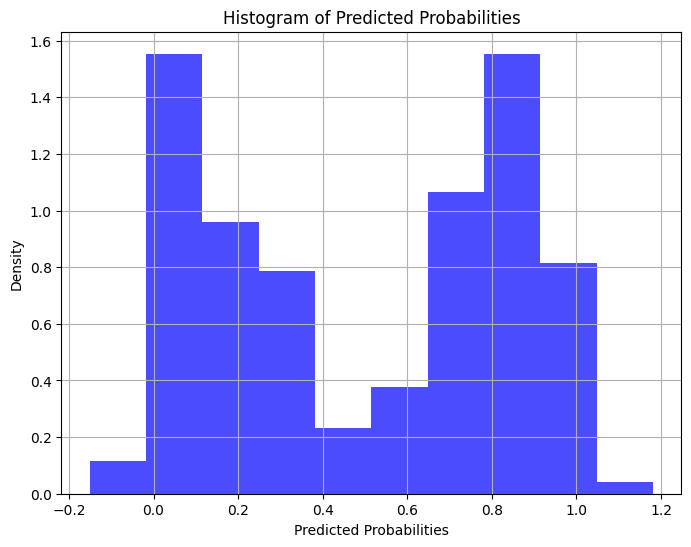

In [ ]:
# Listing 5.9 Testing a gradient boosting regression class

class GradientBoostingRegression(GradientBoosting):

    def fit(self, X, y):
        self.init = np.mean(y) #A
        y_pred = self.init * np.ones((X.shape[0],))

        for k in range(self.n_estimators):
            gradient = self.gradient(y, y_pred)
            tree = DecisionTreeRegressor(**self.params)
            tree.fit(X, -gradient) #B
            self.trees.append(tree)
            y_pred += self.learning_rate * tree.predict(X) #C

    def predict(self, X):
        y_pred = self.init * np.ones((X.shape[0],))
        for tree in self.trees:
            y_pred += self.learning_rate * tree.predict(X) #D
        return y_pred

reg = GradientBoostingRegression(n_estimators=300,
                                 learning_rate=0.1,
                                 max_depth=4,
                                 min_samples_leaf=3, 
                                 random_state=0)

reg.fit(X, y)

proba = reg.predict(Xt)
plt.figure(figsize=(8, 6))
plt.hist(proba, bins=10, density=True, color='blue', alpha=0.7) #E
plt.xlabel('Predicted Probabilities')
plt.ylabel('Density')
plt.title('Histogram of Predicted Probabilities')
plt.grid(True)
plt.show()

#A initializing predictions with mean of y
#B fitting the tree to the negative gradient
#C updating predictions with tree's predictions scaled by learning rate
#D predicting back requires cumulating predictions from all the trees
#E plotting a histogram of regression predicted probabilities

In [ ]:
# Listing 5.10 Scikit-learn gradient boosting classifier

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
accuracy = make_scorer(accuracy_score)
cv = KFold(5, shuffle=True, random_state=0)
model = GradientBoostingClassifier(n_estimators=300,
                                   learning_rate=0.1,
                                   max_depth=4,
                                   min_samples_leaf=3, 
                                   random_state=0) #A

model_pipeline = Pipeline(
    [('processing', column_transform),
     ('modeling', model)]) #B

cv_scores = cross_validate(estimator=model_pipeline, 
                           X=data, 
                           y=target_median,
                           scoring=accuracy,
                           cv=cv, 
                           return_train_score=True,
                           return_estimator=True) #C

mean_cv = np.mean(cv_scores['test_score'])
std_cv = np.std(cv_scores['test_score'])
fit_time = np.mean(cv_scores['fit_time'])
score_time = np.mean(cv_scores['score_time'])
print(f"{mean_cv:0.3f} ({std_cv:0.3f})", 
      f"fit: {fit_time:0.2f} secs pred: {score_time:0.2f} secs") #D

#A a GradientBoostingClassifier model with specified hyperparameters
#B a pipeline that first applies data processing with column_transform and then fits the model
#C a five-fold cross-validation using the defined pipeline, calculating accuracy scores, and returning additional information
#D printing the mean and standard deviation of the accuracy scores from cross-validation

0.826 (0.004) fit: 13.62 secs pred: 0.06 secs


In [ ]:
# Listing 5.11 Applying early stopping with GradientBoostingClassifier

model = GradientBoostingClassifier(n_estimators=1000, #A
                                   learning_rate=0.1,
                                   validation_fraction=0.2, #B
                                   n_iter_no_change=10, #C
                                   max_depth=4,
                                   min_samples_leaf=3, 
                                   random_state=0)

model_pipeline = Pipeline(
    [('processing', column_transform),
     ('modeling', model)])

cv_scores = cross_validate(estimator=model_pipeline, 
                           X=data, 
                           y=target_median,
                           scoring=accuracy,
                           cv=cv, 
                           return_train_score=True,
                           return_estimator=True)

mean_cv = np.mean(cv_scores['test_score'])
std_cv = np.std(cv_scores['test_score'])
fit_time = np.mean(cv_scores['fit_time'])
score_time = np.mean(cv_scores['score_time'])
print(f"{mean_cv:0.3f} ({std_cv:0.3f})", 
      f"fit: {fit_time:0.2f} secs pred: {score_time:0.2f} secs")
iters = [cv_scores["estimator"][i].named_steps["modeling"].n_estimators_ 
         for i in range(5)]  #D
print(iters) #E

#A a GradientBoostingClassifier model whose iterations are raised to 1000 from the previous 300
#B as a validation fraction, the GradientBoostingClassifier uses 20% of the training data for validation
#C the training of the GradientBoostingClassifier will stop after 10 iterations without improvements on the validation
#D extracting the number of estimators used during training for each fold's estimator
#E printing the list of the number of estimators for each fold's estimator

0.826 (0.005) fit: 5.48 secs pred: 0.04 secs
[145, 109, 115, 163, 159]


In [ ]:
# Listing 5.12 XGBoost classifier

from xgboost import XGBClassifier

accuracy = make_scorer(accuracy_score)
cv = KFold(5, shuffle=True, random_state=0)
xgb = XGBClassifier(booster='gbtree', #A
                    objective='reg:logistic', #B
                    n_estimators=300,
                    max_depth=4,
                    min_child_weight=3) #C

model_pipeline = Pipeline(
    [('processing', column_transform),
     ('xgboost', xgb)])

cv_scores = cross_validate(estimator=model_pipeline, 
                           X=data, 
                           y=target_median,
                           scoring=accuracy,
                           cv=cv, 
                           return_train_score=True,
                           return_estimator=True)

mean_cv = np.mean(cv_scores['test_score'])
std_cv = np.std(cv_scores['test_score'])
fit_time = np.mean(cv_scores['fit_time'])
score_time = np.mean(cv_scores['score_time'])
print(f"{mean_cv:0.3f} ({std_cv:0.3f})", 
      f"fit: {fit_time:0.2f} secs pred: {score_time:0.2f} secs") #D

#A creating an XGBClassifier model with specified hyperparameters, including the booster type
#B The learning objective, equivalent to Scikit-learn’s loss
#C min_child_weight is equivalent as Scikit-learn’s min_samples_leaf
#D printing the mean and standard deviation of cross-validated test scores

0.825 (0.004) fit: 4.56 secs pred: 0.04 secs


In [ ]:
# Listing 5.13 Explaining how XGBoost works

class NewtonianGradientBoosting(GradientBoosting): #A
    """the Newton-Raphson method is used to update the predictions"""
    
    reg_lambda = 0.25 #B
    
    def hessian(self, y_true, y_pred):
        hessian = np.ones_like(y_true) #C
        return hessian
    
    def fit(self, X, y):
        self.init = self.logit(np.mean(y))
        y_pred = self.init * np.ones((X.shape[0],))
        
        for k in range(self.n_estimators):
            gradient = self.gradient(self.logit(y), y_pred)
            hessian = self.hessian(self.logit(y), y_pred)
            tree = DecisionTreeRegressor(**self.params)
            tree.fit(X, -gradient / (hessian + self.reg_lambda)) #D 
            self.trees.append(tree)
            y_pred += self.learning_rate * tree.predict(X)
        
cls = NewtonianGradientBoosting(n_estimators=300,
                                learning_rate=0.1,
                                max_depth=4,
                                min_samples_leaf=3, 
                                random_state=0) #E

cls.fit(X, y) #F
preds = cls.predict(Xt)
score = accuracy_score(y_true=yt, y_pred=preds)
print(f"Accuracy: {score:0.5f}") #G

#A defining a new class NewtonianGradientBoosting as a subclass of GradientBoosting
#B setting a regularization parameter reg_lambda
#C initializing a constant hessian matrix with ones
#D fitting the decision tree by dividing the negative gradient by the sum of the hessian and the regularization parameter
#E creating an instance of the NewtonianGradientBoosting class with specified hyperparameters
#F fitting the NewtonianGradientBoosting model to the training data
#G predicting target values using the fitted model and calculating the accuracy score for evaluation

Accuracy: 0.82514


In [ ]:
# Listing 5.14 Explaining the histogram split

import numpy as np

def gini_impurity(y):
    _, counts = np.unique(y, return_counts=True)
    probs = counts / len(y)
    return 1 - np.sum(probs**2) #A

def histogram_split(x, y, use_histogram, n_bins=256):
    if use_histogram:
        hist, thresholds = np.histogram(x, bins=n_bins, density=False) #B
    else:
        thresholds = np.unique(x) #C
    best_score = -1
    best_threshold = None #D
    for threshold in thresholds: #E
        left_mask = x <= threshold
        right_mask = x > threshold
        left_y = y[left_mask]
        right_y = y[right_mask] #F
        score = (gini_impurity(left_y) * len(left_y) 
                 + gini_impurity(right_y) * len(right_y)) #G
        if score > best_score: #H
            best_threshold = threshold
            best_score = score
    return best_threshold, best_score #I

#A function calculating and returning the Gini impurity of a set of labels y
#B if use_histogram is true, computes the histogram for the selected feature
#C if use_histogram is false, just enumerates all the unique value in the feature
#D initializing the best score and threshold
#E iterating over all possible thresholds
#F splitting y based into left and right subsets based on the selected threshold
#G calculating the Gini impurity score for the left and right subsets 
#H updating the best score and threshold if the current split has a higher Gini impurity score than the previous best split
#I returning the best threshold and its corresponding Gini impurity score

In [ ]:
%%time
histogram_split(x=data.latitude, y=target_median, use_histogram=False)

CPU times: user 34.9 s, sys: 47.9 ms, total: 35 s
Wall time: 35.1 s


(40.91306, 24447.475447387256)

In [ ]:
%%time
histogram_split(x=data.latitude, y=target_median, use_histogram=True, n_bins=256)

CPU times: user 380 ms, sys: 0 ns, total: 380 ms
Wall time: 382 ms


(40.91306, 24447.475447387256)

In [ ]:
# Listing 5.15 Applying early stopping to XGBoost

train, test = train_test_split(range(len(data)), test_size=0.2, random_state=0) #A
train, validation = train_test_split(train, test_size=0.2, random_state=0) #B

xgb = XGBClassifier(booster='gbtree',
                    objective='reg:logistic',
                    n_estimators=1000,
                    max_depth=4,
                    min_child_weight=3,
                    early_stopping_rounds=100,  #C
                    eval_metric='error')  #D

X = column_transform.fit_transform(data.iloc[train])
y = target_median[train]

Xv = column_transform.transform(data.iloc[validation])
yv = target_median[validation]

xgb.fit(X, y, eval_set=[(Xv, yv)], verbose=False) #E

Xt = column_transform.transform(data.iloc[test])
yt = target_median[test]

preds = xgb.predict(Xt)
score = accuracy_score(y_true=yt, y_pred=preds)
print(f"Accuracy: {score:0.5f}") #F

#A splitting the indices of the data into training and test sets using a fixed random seed
#B further splitting the training set into training and validation sets using the same random seed
#C initializing an XGBoost classifier with an early stopping patience for 100 rounds
#D using the ‘error’ parameter, equivalent to accuracy, as an evaluation metric
#E fitting the XGBoost classifier to the training data X and labels y and performance on the validation data Xv and yv
#F print the accuracy score after comparing the predicted labels with the true labels

Accuracy: 0.82606


In [ ]:
# Listing 5.16 LightGBM classifier

from lightgbm import LGBMClassifier

accuracy = make_scorer(accuracy_score)
cv = KFold(5, shuffle=True, random_state=0)
lgbm = LGBMClassifier(boosting_type='gbdt',
                      n_estimators=300,
                      max_depth=4,
                      min_child_samples=3) #A

model_pipeline = Pipeline(
    [('processing', column_transform),
     ('lightgbm', lgbm)]) #B

cv_scores = cross_validate(estimator=model_pipeline, 
                           X=data, 
                           y=target_median,
                           scoring=accuracy,
                           cv=cv, 
                           return_train_score=True,
                           return_estimator=True) #C

mean_cv = np.mean(cv_scores['test_score'])
std_cv = np.std(cv_scores['test_score'])
fit_time = np.mean(cv_scores['fit_time'])
score_time = np.mean(cv_scores['score_time'])
print(f"{mean_cv:0.3f} ({std_cv:0.3f})", 
      f"fit: {fit_time:0.2f} secs pred: {score_time:0.2f} secs") #D 

#A Initializing an LGBMClassifier with number of estimators, maximum tree depth, and minimum number of child samples
#B creating a model pipeline that includes a column transformation step and an LGBMClassifier step
#C performing a five-fold cross-validation using the model pipeline using accuracy scoring
#D printing the mean test score and standard deviation of the test scores obtained during cross-validation

0.827 (0.004) fit: 0.54 secs pred: 0.09 secs


In [ ]:
# Listing 5.17 Applying early stopping to LightGBM

from lightgbm import LGBMClassifier, log_evaluation

train, test = train_test_split(range(len(data)), test_size=0.2, random_state=0) #A
train, validation = train_test_split(train, test_size=0.2, random_state=0) #B

lgbm = LGBMClassifier(boosting_type='gbdt', 
                      n_estimators=1000, 
                      max_depth=4,
                      min_child_samples=3) #C

X = column_transform.fit_transform(data.iloc[train])
y = target_median[train]

Xv = column_transform.transform(data.iloc[validation])
yv = target_median[validation]

lgbm.fit(X, y, eval_set=[(Xv, yv)], #D
     	early_stopping_rounds=100, #E
     	eval_metric='accuracy', #F
     	callbacks=[log_evaluation(period=0)]) #G

Xt = column_transform.transform(data.iloc[test])
yt = target_median[test]

preds = xgb.predict(Xt)
score = accuracy_score(y_true=yt, y_pred=preds)
print(f"Accuracy: {score:0.5f}") #H

#A splitting the indices of the data into training and test sets using a fixed random seed
#B further splitting the training set into training and validation sets using the same random seed
#C initializing a LightGBM classifier with number of estimators, max depth and minimum number of child samples
#D fitting the LightGBM classifier to the training data X and labels y and performance on the validation data Xv and yv
#E setting at fitting time an early stopping patience of 100 rounds
#F setting accuracy as an evaluation metric
#G setting a callback to suppress the evaluation (period=0)
#H print the accuracy score after comparing the predicted labels with the true labels

/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


Accuracy: 0.82606


In [ ]:
# Listing 5.18 The new Scikit-learn’s histogram gradient boosting

from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import accuracy_score

accuracy = make_scorer(accuracy_score)
cv = KFold(5, shuffle=True, random_state=0)

model = HistGradientBoostingClassifier(learning_rate=0.1,
                                       max_iter=300,
                                       max_depth=4,
                                       min_samples_leaf=3,
                                       random_state=0) #A

model_pipeline = Pipeline(
    [('processing', column_transform),
     ('modeling', model)]) #B

cv_scores = cross_validate(estimator=model_pipeline, 
                           X=data, 
                           y=target_median,
                           scoring=accuracy,
                           cv=cv, 
                           return_train_score=True,
                           return_estimator=True) #C

mean_cv = np.mean(cv_scores['test_score'])
std_cv = np.std(cv_scores['test_score'])
fit_time = np.mean(cv_scores['fit_time'])
score_time = np.mean(cv_scores['score_time'])
print(f"{mean_cv:0.3f} ({std_cv:0.3f})", 
      f"fit: {fit_time:0.2f} secs pred: {score_time:0.2f} secs") #D 

#A initializing a HistGradientBoostingClassifier with specific hyperparameters for the boosting algorithm
#B creating a model pipeline combining data preprocessing (column_transform) and the model
#C executing five-fold cross-validation on the model pipeline returning scores and trained estimators
#D printing the mean and standard deviation of the accuracy scores from cross-validation

0.827 (0.005) fit: 1.30 secs pred: 0.10 secs
